In [3]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D

from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report


In [4]:
len(os.listdir("../input/chest-xray-covid19-pneumonia/Data/train/COVID19"))

460

> The dataset is divided into two sets: 
> 1. Train set 
> 2. Validation set

# 📉 Data Visualization

In [5]:
!ls

__notebook_source__.ipynb


In [6]:
train_dir = "../input/chest-xray-covid19-pneumonia/Data/train/"
test_dir = "../input/chest-xray-covid19-pneumonia/Data/test/"

print("Train set:\n========================================")
num_covid = len(os.listdir(os.path.join(train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"COVID={num_covid}")
print(f"NORMAL={num_normal}")

print("\nTest set:\n========================================")
print(f"COVID = {len(os.listdir(os.path.join(test_dir, 'COVID19')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

# print("Validation set:\n========================================")
# print(f"COVID = {len(os.listdir(os.path.join(val_dir, 'COVID19')))}")
# print(f"NORMAL = {len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
COVID=460
NORMAL=1266

Test set:
COVID = 116
NORMAL = 317


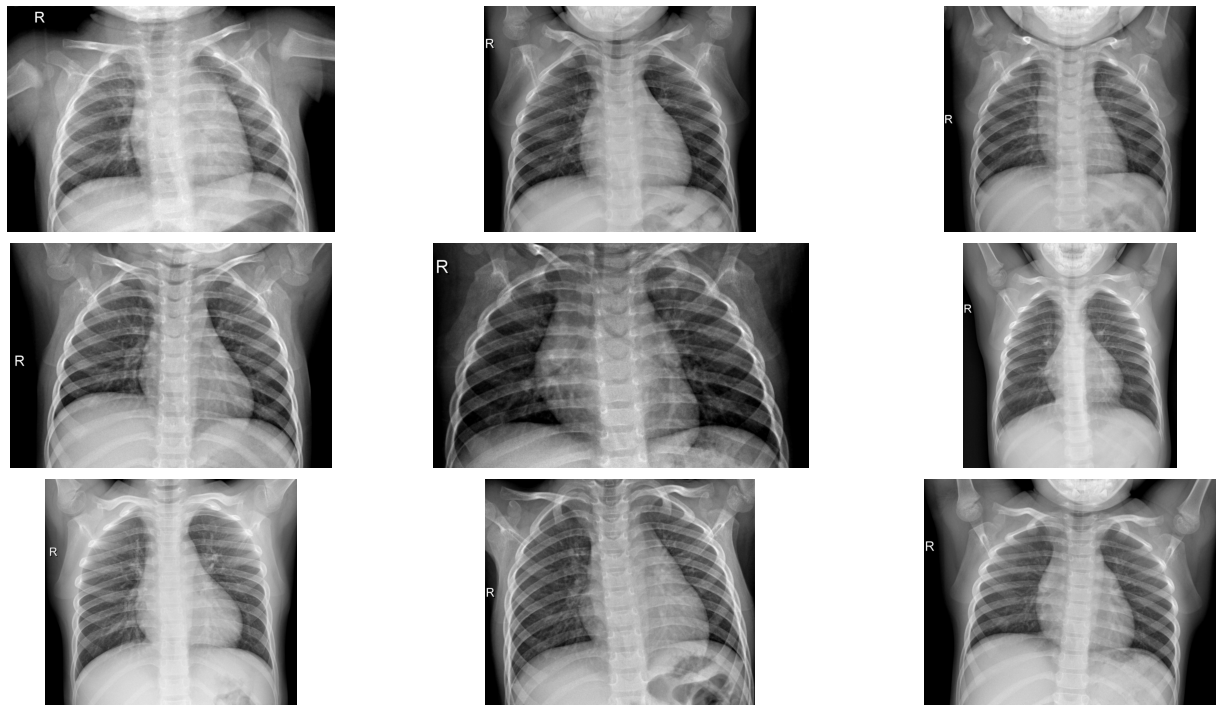

In [7]:
normal = os.listdir("../input/chest-xray-covid19-pneumonia/Data/train/NORMAL")
normal_dir = "../input/chest-xray-covid19-pneumonia/Data/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

# 🔍 Investigate a single image

The dimensions of the image are 1013 pixels width and 1472 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 132.8995 and the standard deviation is 67.1453


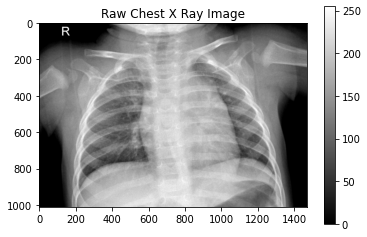

In [8]:
normal_img = os.listdir("../input/chest-xray-covid19-pneumonia/Data/train/NORMAL")[0]
normal_dir = "../input/chest-xray-covid19-pneumonia/Data/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# 🔍 Ivestigate pixel value distribution

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

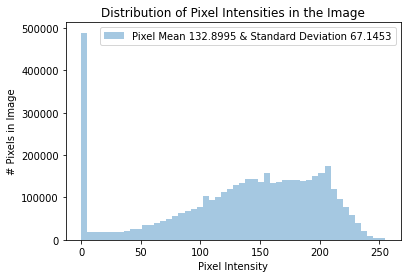

In [9]:
sns.distplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 🔄 Image Preprocessing

> Before training, you'll first modify your images to be better suited for training a convolutional neural network. For this task you'll use the Keras `ImageDataGenerator` function to perform data preprocessing and data augmentation.

> - This class also provides support for basic data augmentation such as random horizontal flipping of images.
> - We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution).
> - The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).



In [10]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

✔️ **Build a separate generator for test sets**

> Now we need to build a new generator for testing data.

✔️ **Why can't use the same generator as for the training data?**

> Look back at the generator we wrote for the training data.
> - It normalizes each image per batch, meaning that it uses batch statistics.
> - We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
> - Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).

> What we need to do is to normalize incomming test data using the statistics computed from the training set.

In [11]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            classes = ["NORMAL", "COVID19"],
                                            class_mode='binary',
                                            target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            classes = ["NORMAL", "COVID19"],
                                            class_mode='binary',
                                            target_size=(320, 320))

Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


The dimensions of the image are 320 pixels width and 320 pixels height, one single color channel.
The maximum pixel value is 2.5836 and the minimum is -2.8574
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


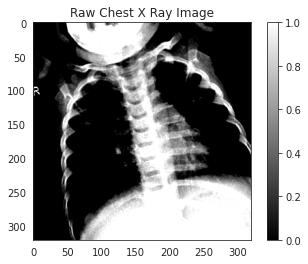

In [12]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

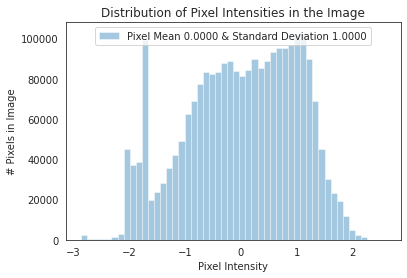

In [13]:
sns.distplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 🤖 Model Building

> One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets.

## ✔️ Impact of imbalance data on loss function

> Loss Function:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

> We can rewrite the the overall average cross-entropy loss over the entire training set `D` of size `N` as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



> When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [14]:
# Class weights

weight_for_0 = num_covid / (num_normal + num_covid)
weight_for_1 = num_normal / (num_normal + num_covid)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.27
Weight for class 1: 0.73


In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
input_t = tf.keras.Input(shape = (320, 320, 3))

vgg_base = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet', input_tensor = input_t)


model = Sequential([
    vgg_base,
    Flatten(),
    Dropout(0.25),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',f1_m, precision_m, recall_m])

2022-12-02 02:36:37.938566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 02:36:37.939528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 02:36:38.091887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 02:36:38.092812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 02:36:38.093702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 10, 10, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6553728   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 21,268,545
Trainable params: 21,268,545
Non-trainable params: 0
____________________________________________

In [18]:
r = model.fit(
    train, 
    epochs=20,
    class_weight=class_weight,
)

2022-12-02 02:36:44.846635: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-12-02 02:36:48.740860: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


216/216 [==============================] - 157s 653ms/step - loss: 0.3061 - accuracy: 0.3586 - f1_m: 0.3420 - precision_m: 0.2406 - recall_m: 0.7423
Epoch 2/20
216/216 [==============================] - 122s 562ms/step - loss: 0.2710 - accuracy: 0.3158 - f1_m: 0.3267 - precision_m: 0.2212 - recall_m: 0.7596
Epoch 3/20
216/216 [==============================] - 122s 562ms/step - loss: 0.2710 - accuracy: 0.5284 - f1_m: 0.1593 - precision_m: 0.1106 - recall_m: 0.3499
Epoch 4/20
216/216 [==============================] - 121s 558ms/step - loss: 0.2710 - accuracy: 0.5400 - f1_m: 0.1343 - precision_m: 0.0885 - recall_m: 0.3426
Epoch 5/20
216/216 [==============================] - 121s 558ms/step - loss: 0.2710 - accuracy: 0.3975 - f1_m: 0.2777 - precision_m: 0.1861 - recall_m: 0.6574
Epoch 6/20
216/216 [==============================] - 121s 558ms/step - loss: 0.2710 - accuracy: 0.4647 - f1_m: 0.2169 - precision_m: 0.1433 - recall_m: 0.5231
Epoch 7/20
216/216 [==============================]

Text(0.5, 1.0, 'VGG16 Accuracy Evolution')

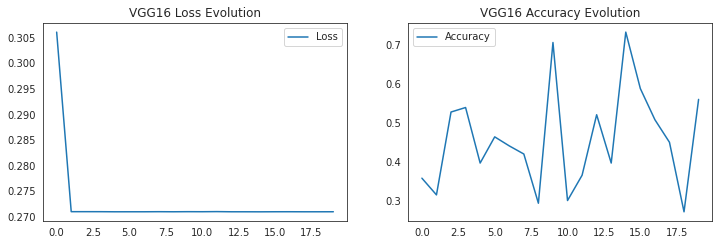

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.title('VGG16 Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('VGG16 Accuracy Evolution')

In [20]:
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

[[317   0]
 [116   0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.732102,0.0,0.732102,0.366051,0.535973
recall,1.000000,0.0,0.732102,0.500000,0.732102
f1-score,0.845333,0.0,0.732102,0.422667,0.618870
support,317.000000,116.0,0.732102,433.000000,433.000000


In [21]:
print(test.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [22]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[317   0]
 [116   0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.732102,0.0,0.732102,0.366051,0.535973
recall,1.000000,0.0,0.732102,0.500000,0.732102
f1-score,0.845333,0.0,0.732102,0.422667,0.618870
support,317.000000,116.0,0.732102,433.000000,433.000000


In [23]:
print(test.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [24]:
print(len(test))

433


In [25]:
model.save("VGG16Model.h5")